## Introduction

The third tutorial for structure queries using RDKit to find matching 2D structure in organic molecules using SMARTS rqueries.

In [76]:
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import pandas as pd
import pubchempy

In [5]:
import time
print(time.asctime()) #return by local time

Wed Aug 17 15:02:45 2022


In [6]:
# some heterocycles 
naphthalene = Chem.MolFromSmiles('c12ccccc1cccc2')
benzoxazole = Chem.MolFromSmiles('n1c2ccccc2oc1')
indane = Chem.MolFromSmiles('c1ccc2c(c1)CCC2')
skatole = Chem.MolFromSmiles('CC1=CNC2=CC=CC=C12')
benzene = Chem.MolFromSmiles('c1ccccc1')
quinoline = Chem.MolFromSmiles('n1cccc2ccccc12')

my_molecules = [naphthalene, 
                benzoxazole,
                indane,
                skatole,
                benzene,
                quinoline,
               ]

The test molecules for this notebook will be the arbitary set ofheterocycles and homocycles(and benzene) above.

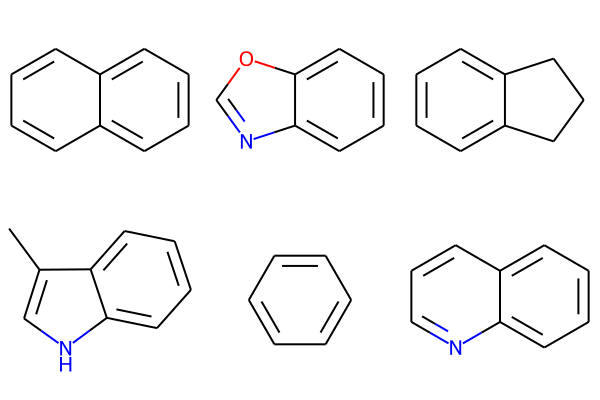

In [7]:
Draw.MolsToGridImage(my_molecules)

For RDKit molecules created via SMILES, ring properties are instantiated automatically on molecule creation. Thus, the code below that tests whethere any atom in each molecule is a member of exactly two SSSR(smallest set of smallest ring) rings works right off the bat. As expected, all molecules have ( at least one atom that is in) two rings, except for the fith molecule, bezene.

In [8]:
is_in_two_rings = Chem.MolFromSmarts('[R2]')
[mol.HasSubstructMatch(is_in_two_rings) for mol in my_molecules]

[True, True, True, True, False, True]

#### Defining substructure queries

SMARTS is a chemical structure query language, RDKit can import SMARTS queries for use in searching against sets of existing RDKit molecules. [Here's a link](https://rdkit.org/docs/RDKit_Book.html#smarts-support-and-extensions) to the documentation about the RDKit's SMARTS support and the extensions it includes.

#### SMARTS query for any five-membered ring fused to a benzene ring

In [10]:
benzo_five = Chem.MolFromSmarts('[*r5R1]1[cR2]2[cR1][cR1][cR1][cR1][cR2]2[*r5R1][*r5R1]1')

#### SMARTS query for any six-membered ring fused to a benzene ring

In [12]:
benzo_six = Chem.MolFromSmarts('[*r6R1]1[cR2]2[cR1][cR1][cR1][cR1][cR2]2[*r6R1][*r6R1][*r6R1]1')

In [13]:
smarts_queries = [benzo_five, benzo_six]

Usings SMARTS instead of SMILES to initialize molecules does not result in instantiation of a molecules's RingInfo property. Thus, until Chem.GetSSSR() is invoked on a SMARTS-derived molecule, certain queries will fail.

In [15]:
#our first try
try:
    print([mol.HasSubstructMatch(is_in_two_rings) for mol in smarts_queries])
    print("Success! Your query worked")
except RuntimeError as err:
    print("ERROR; {0} becuase RingInfo wasn\'t initialized\n".format(err))

# initialize rings
[Chem.GetSSSR(mol) for mol in smarts_queries]

# now it works
try:
    print([mol.HasSubstructMatch(is_in_two_rings) for mol in smarts_queries])
    print("Success! Your query worked.\n")
except RuntimeError as err:
    print("ERROR: {0} becuase RingInfo wasn\'t initialized".format(err))

ERROR; Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code\GraphMol\RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.03.4
	BOOST: 1_75
 becuase RingInfo wasn't initialized

[True, True]
Success! Your query worked.



[15:25:03] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file C:\rdkit\build\temp.win-amd64-cpython-310\Release\rdkit\Code\GraphMol\RingInfo.cpp
Failed Expression: df_init
****



Now that our query molecules'RingInfo is instantiated, it will be possible to compute meaningful 2D sets of coordinates for the SMARTS molecules and to both(a) query against the SMARTS molecule and (b)use the SMARTS molecule as query against other molecules. Without calling Chem.GetSSSR(), only the second option would be viable.

In [16]:
[AllChem.Compute2DCoords(mol) for mol in smarts_queries]

[0, 0]

In [17]:
# matching the first query
for mol in my_molecules:
    AllChem.GenerateDepictionMatching2DStructure(mol, benzo_five, acceptFailure=True)

Our matching to our first query is done, now all we have to do is draw the results.

### Five-membered rings fused to benzene ring

The trick here is that the IPythonConsole module of rdkit.Chem.Draw doesn't seem to pass through the highlightSubstructs = True parameter to the appropriate rendering function, even though it does result in setting the mol.__sssAtoms property for each molecule. We can pass this parameter manually.

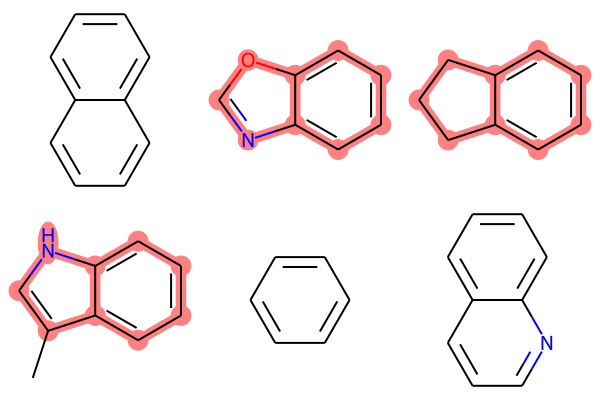

In [109]:
highligh_lists = [mol.GetSubstructMatch(benzo_five) for mol in my_molecules]
Draw.MolsToGridImage(my_molecules, highlightAtomLists= highligh_lists)

The graph above shows that skatole, indane, and benzoxazole hit our first query, which tested whether a molecule contained a benzene fused to a five-membered ring. The skatole example illustrate that not all atoms in a molecule need to match a query , and also tha only those atoms that match will be highlighted.

As expected, benzene isn't highlighted becuase it doesn't contain two rings, and nephthalene and quinoline aren't highlighted because they contain benzene fused to a six-membered ring.

### Six-membered rings fused to benzene

The other query was to check for benzene fused to six-membered rings. This should hit naphthalene and quinoline.

In [121]:
for mol in my_molecules:
    AllChem.GenerateDepictionMatching2DStructure(mol, benzo_six, acceptFailure=True)

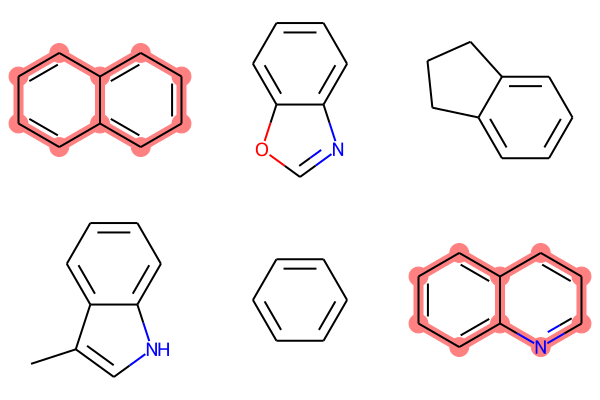

In [126]:
#make sure the molecules are storing information about the SSS match:
highligh_lists = [mol.GetSubstructMatch(benzo_six) for mol in my_molecules]
Draw.MolsToGridImage(my_molecules, highlightAtomLists=highligh_lists,)

### Testing molecules from delaney dataset

In [124]:
path = os.getcwd()
url = "https://raw.githubusercontent.com/jamesleocodes/rdkit_basics/master/data/delaney.csv"
data = pd.read_csv(url, usecols = ["SMILES"])

ms = [Chem.MolFromSmiles(x) for x  in data["SMILES"]]

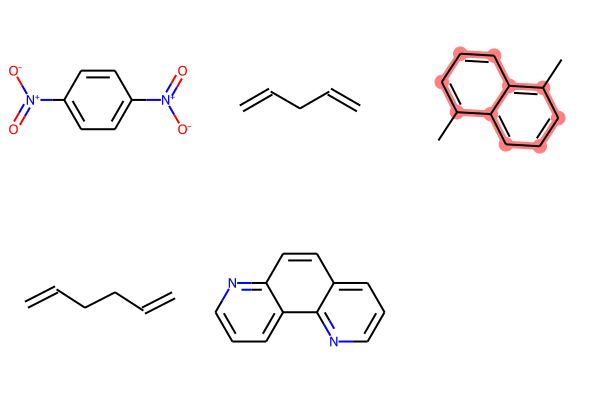

In [127]:
highligh_lists = [mol.GetSubstructMatch(benzo_six) for mol in ms[50:55]]
Draw.MolsToGridImage(ms[50:55], highlightAtomLists= highligh_lists)